In [1]:
import numpy as np
import matplotlib.pyplot as plt


Below, we will use a state space model to make predictions of stock prices from a historical stock market dataset.

For linear dynamical systems modeling, we'll use the SSM package from here:
https://github.com/lindermanlab/ssm

To install the SSM package, run the following lines of code (copied from the Github page above) in the terminal:

    git clone https://github.com/lindermanlab/ssm
    cd ssm
    pip install numpy cython
    pip install -e .
    
Or the following also works:

    !pip install git+https://github.com/lindermanlab/ssm

To test that everything is working, here is a simple example in which a hidden Markov model with random parameters is created, sampled from, and fit using the SSM package:

In [2]:
import ssm
T = 100  # number of time bins
K = 5    # number of discrete states
D = 2    # dimension of the observations

# Create an HMM as a generative model and sample from it:
hmm = ssm.HMM(K, D, observations="gaussian")
z, y = hmm.sample(T)
print('True hidden states: ', z)

# Fit the hmm and print the inferred hidden states 
# (remember that the labels might not correspond to those for the true model):
test_hmm = ssm.HMM(K, D, observations="gaussian")
test_hmm.fit(y)
zhat = test_hmm.most_likely_states(y)
print('Inferred hidden states: ', zhat)


True hidden states:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 3 3
 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


  0%|          | 0/100 [00:00<?, ?it/s]

Inferred hidden states:  [3 3 3 3 3 0 0 0 0 0 0 0 3 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 3 3 3 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 0 0 0 0 3 3 3 3 3 0 0 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1]


## Stock price prediction

In what follows, we'll use an LDS state space model to try to predict stock prices over time. We'll use historical data adapted from here: 

https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

The data has been preprocessed a bit to get it into a nice format. It is in the form of a 2D Numpy array, where each row corresponds to a day on which the stock market was open during the years 2000-2017, and each column corresponds to a publicly traded company. (If you are curious, the file company_list.txt provides the abbreviated names of the companies that are included in the dataset.) Each entry in the array gives the opening stock price for a particular company on a particular day.

**Disclaimer**: Before you go and invest all of your graduate student stipend in the market based on this exercise, please consider the following:
1. This version of the dataset is biased because it includes only companies that existed throughout the period 2000-2017. It excludes companies that appeared or disappeared at any point during that time.
2. In cases where stock prices were missing for some days for some companies, the price from that company from the nearest adjacent day was used to fill in the missing data.
3. This assignment was written by someone who knows next to nothing about sound investment strategy.

In [3]:
# Load the data: 
prices = np.load('prices.npy')
n_days, n_companies = np.shape(prices)
print('n_days, n_companies: ', n_days, n_companies)

n_days, n_companies:  6521 106


Text(0, 0.5, 'Price ($)')

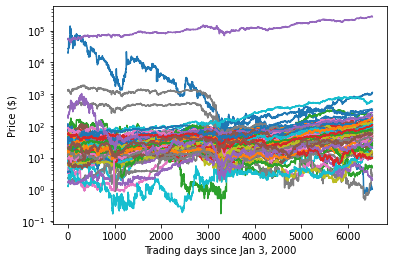

In [4]:
# Look at the data:

plt.semilogy(prices[:,:])
plt.xlabel('Trading days since Jan 3, 2000')
plt.ylabel('Price ($)')

Average return:  5.4499346225389855


Text(0, 0.5, 'Normalized price')

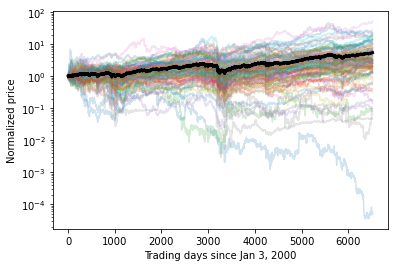

In [5]:
# Normalize each line by its value on the first day:
starting_prices = prices[0,:]
prices_norm = prices / starting_prices

# The average normalized stock price (with all companies weighted equally):
market_average = np.mean(prices_norm, axis=1)

# The return per dollar invested if investing equally in all companies:
avg_return = market_average[-1]/market_average[0]
print('Average return: ', avg_return)

# Plot the normalized data:
plt.semilogy(prices_norm, alpha=0.2)
plt.semilogy(market_average, c='k', lw=3)
plt.xlabel('Trading days since Jan 3, 2000')
plt.ylabel('Normalized price')

The LDS model is described by the following equations:
$$
p(\mathbf{z}_n | \mathbf{z}_{n-1}) 
= \mathcal{N}(\mathbf{z}_n | \mathbf{Az}_{n-1}, \mathbf{\Gamma}) \\
p(\mathbf{x}_n | \mathbf{z}_n)
= \mathcal{N} (\mathbf{x}_n | \mathbf{Cz}_n + \mathbf{d}, \mathbf{\Sigma}),
$$
where the covariance matrix $\mathbf{\Sigma}$ is assumed to be diagonal, so it appears as a vector (i.e. just the diagonal elements) rather than as a matrix below. Note also the presence of a bias vector $\mathbf{d}$ in the emission model, which is not present in the textbook example that we discussed in class.

In the following block of code, we'll fit an LDS model to the stock data and plot the inferred latent states.

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'Latent state')

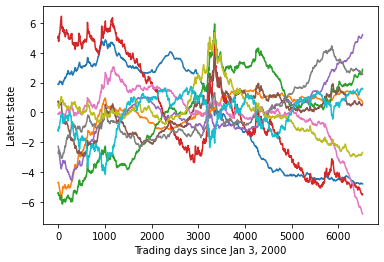

In [92]:
# Set the parameters of the LDS:
time_bins = n_days   # number of time bins
state_dim = 10     # number of latent dimensions
obs_dim = n_companies      # number of observed dimensions

# Because prices vary over many orders of magnitude, we'll use the log:
data = np.log(prices_norm)

# Fit the model using the full dataset:
lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian")
elbos, q = lds.fit(data, method="laplace_em", num_iters=10)

# The model's inferred latent states:
state_means = q.mean_continuous_states[0]

# Plot the inferred latent states:
plt.plot(state_means)
plt.xlabel('Trading days since Jan 3, 2000')
plt.ylabel('Latent state')



In [93]:
# Get the model parameters:
A = lds.dynamics.As[0]
Gamma = lds.dynamics.Sigmas[0]
C = lds.emissions.Cs[0]
d = lds.emissions.ds[0]
Sig = lds.emissions.params[-1][0]

for x in [A, Gamma, C, d, Sig]:
    print(x.shape)

(10, 10)
(10, 10)
(106, 10)
(106,)
(106,)


**Exercise**: Use LDS modeling to see whether you can beat the market. 

(a) Choose a day $d$ in the middle of the dataset and train a model using data from some or all of the preceding days. Use an appropriate method for choosing the dimensionality $K$ of the latent variable, and explain your approach. 

(b) Using the parameters from the model, predict the evolution of the latent states and the most likely observations under the model over, say, the following $\tau = 100$ or so trading days (you can use a different $\tau$ if you like). 

(c) Use this information to determine how you should invest a dollar on day $d$ among different companies to earn a high expected return on day $d+\tau$, explaining the strategy that you're using. 

(d) Then use the data to calculate the actual return that your strategy would yield over this interval, and compare this with what you would have earned by simply dividing your dollar equally among all of the companies. 

(e) By repeating all of the above for many different $d$, quantify whether your model enables you, on average, to obtain better returns than the simpler investment strategy.


  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'Day')

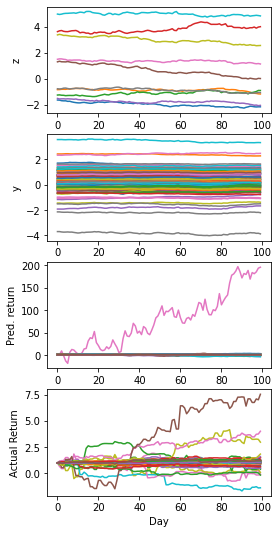

In [125]:
# Choose a particular day, use all of the preceding data to train a model, then predict future prices.

day = 5000

# Fit the model using the full dataset:
lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian")
elbos, q = lds.fit(data[:day,:], method="laplace_em", num_iters=10)

# The model's inferred latent states:
state_means = q.mean_continuous_states[0]

# Sample from the model:
tau = 100  # time horizon
z = np.zeros((tau, state_dim))
y = np.zeros((tau, obs_dim))
z[0,:] = state_means[-1,:]
y[0,:] = C @ z[0,:] + d
for t in range(1, tau):
    z[t,:] = A @ z[t-1,:] + np.random.multivariate_normal(np.zeros(state_dim), Gamma)
    y[t,:] = C @ z[t-1,:] + d

returns_pred = y / y[0,:]
returns_actual = data[day:day+tau,:] / data[day,:]

plt.figure(figsize=(4,9))
plt.subplot(411)
plt.plot(z);
plt.ylabel('z')
plt.subplot(412)
plt.plot(y);
plt.ylabel('y')
plt.subplot(413)
plt.plot(returns_pred);
plt.ylabel('Pred. return')
plt.subplot(414)
plt.plot(returns_actual);
plt.ylabel('Actual Return')
plt.xlabel('Day')

(array([87.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 19.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

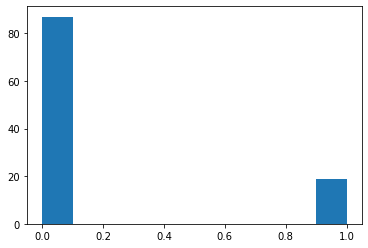

In [126]:
from scipy.special import softmax

# allocate dollar as a softmax distribution based on predicted returns:
#allocation = softmax(y[-1,:])

# allocate dollar evenly among all companies with positive returns:
allocation = 0.5 * (np.sign(y[-1,:]-1) + 1)
#allocation /= np.sum(allocation)

plt.hist(allocation)

In [127]:
print('Return if investing evenly among all companies: ', 
      np.sum(returns_actual)/len(returns_actual))
print('Return if investing among companies according to model: ', 
      np.sum(returns_actual*allocation) / np.sum(allocation))

Return if investing evenly among all companies:  111.14412436830105
Return if investing among companies according to model:  91.58641894519424


In [138]:
# Loop over all of the above for many days.

returns_null = []
returns_strategized = []
for day in range(500, 6500, 100):

    # Fit the model using the full dataset:
    lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian")
    elbos, q = lds.fit(data[:day,:], method="laplace_em", num_iters=10)

    # The model's inferred latent states:
    state_means = q.mean_continuous_states[0]

    # Sample from the model:
    tau = 100  # time horizon
    z = np.zeros((tau, state_dim))
    y = np.zeros((tau, obs_dim))
    z[0,:] = state_means[-1,:]
    y[0,:] = C @ z[0,:] + d
    for t in range(1, tau):
        z[t,:] = A @ z[t-1,:] + np.random.multivariate_normal(np.zeros(state_dim), Gamma)
        y[t,:] = C @ z[t-1,:] + d

    returns_pred = y / y[0,:]
    returns_actual = data[day:day+tau,:] / data[day,:]

    allocation = 0.5 * (np.sign(y[-1,:]-1) + 1)

    returns_null.append(np.sum(returns_actual)/len(returns_actual))
    returns_strategized.append(np.sum(returns_actual*allocation) / np.sum(allocation))

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Mean return if investing evenly among all companies:  84.4401245696751
Mean return if investing among companies according to model:  92.93244454443392


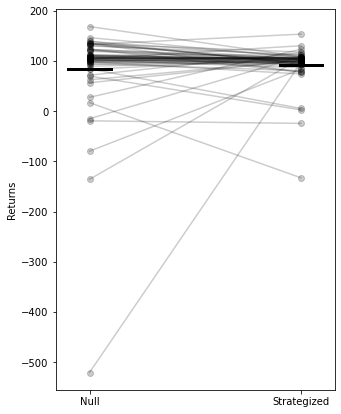

In [141]:
plt.figure(figsize=(5, 7))
for i in range(len(returns_null)):
    plt.plot([0, 1], [returns_null[i], returns_strategized[i]], '-ok', alpha=0.2)
#plt.plot(np.zeros_like(returns_null), returns_null, 'ok')
plt.plot([-0.1, 0.1], np.mean(returns_null)*np.ones(2), 'k', lw=3)
#plt.plot(np.ones_like(returns_strategized), returns_strategized, 'ok')
plt.plot([0.9, 1.1], np.mean(returns_strategized)*np.ones(2), 'k', lw=3)
plt.xticks([0, 1], ['Null', 'Strategized'])
plt.ylabel('Returns')

print('Mean return if investing evenly among all companies: ', 
      np.mean(returns_null))
print('Mean return if investing among companies according to model: ', 
      np.mean(returns_strategized))

In [140]:
from scipy.stats import wilcoxon

res = wilcoxon(np.array(returns_strategized) - np.array(returns_null))
print('p =', res.pvalue)

p = 0.04292481474489162
